In [17]:
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile as wav
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing import image
from keras.utils import to_categorical

EDA

sample_rate
#What is a sample rate

#how many times per second a sound is sampled (standard for CDs is 44100 hertz, but here we're getting 22050 hertz. Thats how many individual audio samples there are in that sound per second)

data
data
#librosa normalizes these values between 0 and 1



#is the dataset balanced?
metadata['class'].value_counts()

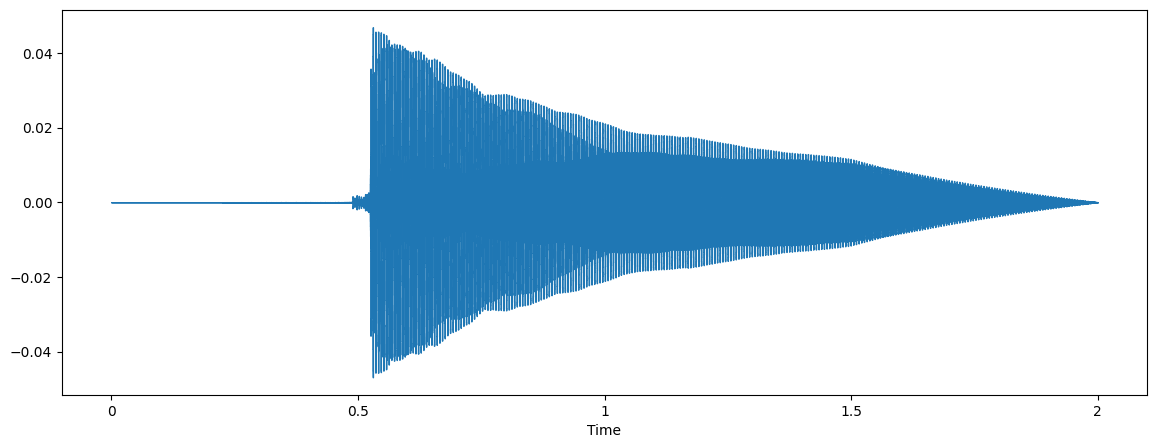

In [18]:
humbucker_ex = 'monoGuitarDataset/humbucker/G63-54304-1111-20701.wav'
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(humbucker_ex)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(humbucker_ex)

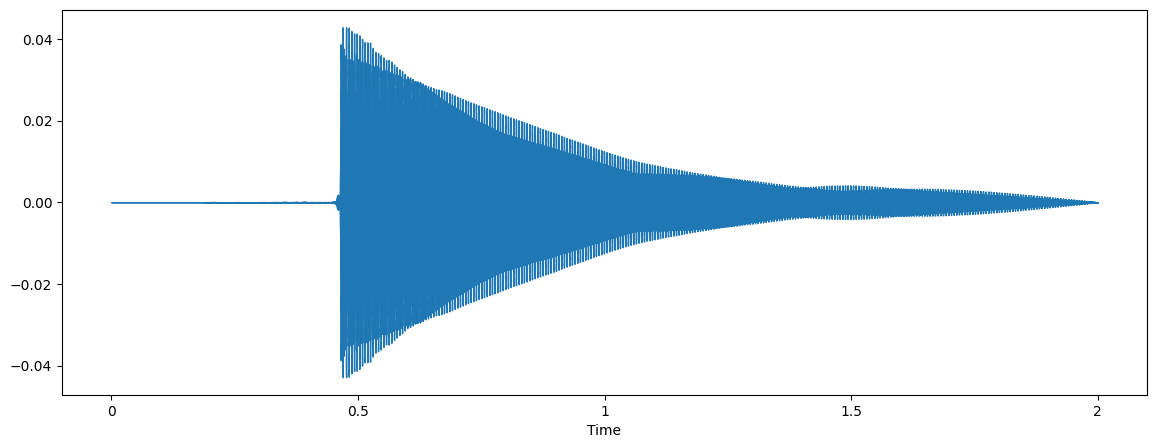

In [19]:
singlecoil_ex = 'monoGuitarDataset/singlecoil/G91-54209-1111-21083.wav'
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(singlecoil_ex)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(singlecoil_ex)

Spectrograms

In [20]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)


create_pngs_from_wavs('monoGuitarDataset/singlecoil', 'Spectrograms/singlecoil')
create_pngs_from_wavs('monoGuitarDataset/humbucker', 'Spectrograms/humbucker')

In [21]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

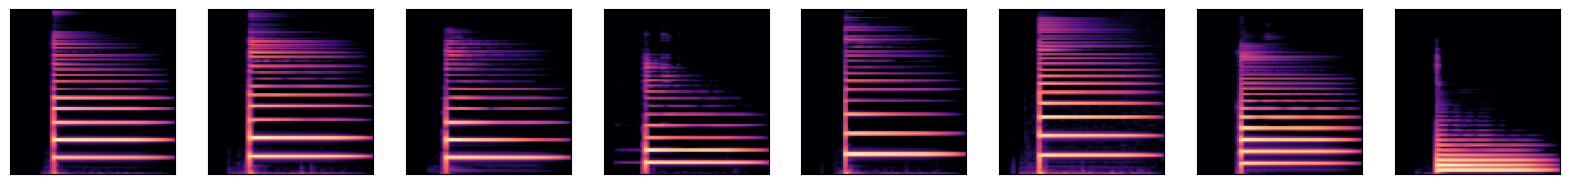

In [22]:
x = []
y = []

images, labels = load_images_from_path('Spectrograms/singlecoil', 0)
show_images(images)
x += images
y += labels

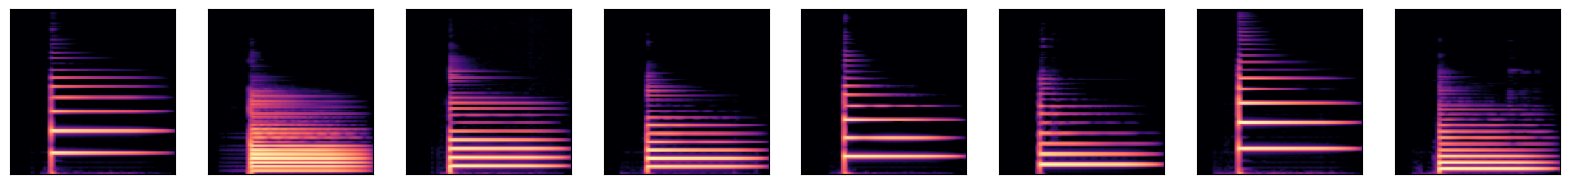

In [23]:
images, labels = load_images_from_path('Spectrograms/humbucker', 1)
show_images(images)
    
x += images
y += labels

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [25]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/aronconnors/anaconda3/envs/guitarClassifier/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,210,498 (73.28 MB)

 Trainable params: 19,210,498 (73.28 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step - accuracy: 0.5926 - loss: 0.9435 - val_accuracy: 0.5266 - val_loss: 0.6873
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 324ms/step - accuracy: 0.5904 - loss: 0.6387 - val_accuracy: 0.8351 - val_loss: 0.4324
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.8558 - loss: 0.2921 - val_accuracy: 0.9415 - val_loss: 0.1150
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.9452 - loss: 0.1629 - val_accuracy: 0.9574 - val_loss: 0.1224
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.9845 - loss: 0.0763 - val_accuracy: 0.9362 - val_loss: 0.1841
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.9717 - loss: 0.0950 - val_accuracy: 0.9734 - val_loss: 0.0803
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - accuracy: 0.9735 - loss: 0.0651 - val_accuracy: 0.9362 - val_loss: 0.3180
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 467ms/step - accuracy: 0.9716 - loss: 0.0999 - val_accu

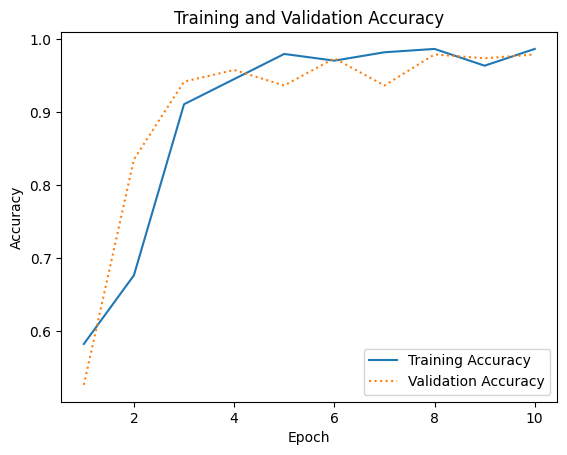

In [27]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [28]:
###DO IT WITH EXAMPLES
#create_pngs_from_wavs('Examples/Sounds/singlecoil', 'Example/Spectrograms/singlecoil')
#create_pngs_from_wavs('Examples/Sounds/humbucker', 'Example/Spectrograms/humbucker')

Test Loss: 0.0590
Test Accuracy: 0.9787
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        94
           1       0.97      0.99      0.98        94

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



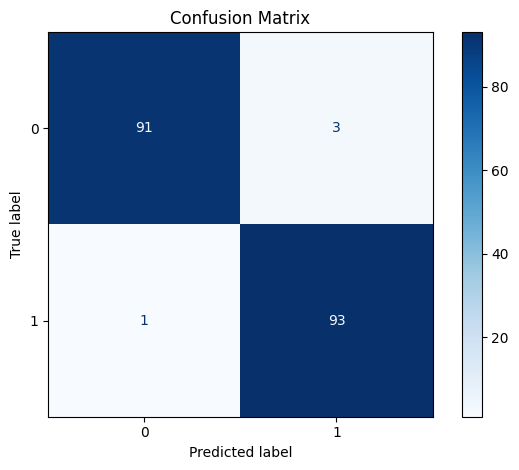

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Check if y_test is one-hot encoded
if y_test_encoded.ndim == 2 and y_test_encoded.shape[1] > 1:
    y_true = np.argmax(y_test_encoded, axis=1)
else:
    y_true = y_test_encoded

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
